<a href="https://colab.research.google.com/github/shirsh19/Concrete-Defect-Detection/blob/main/Honeycomb_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Update the CSV path
csv_path = '/content/drive/MyDrive/NewData.csv'
data_path = '/content/drive/MyDrive/combined_dataset'

Mounted at /content/drive


In [ ]:
# Load data
labels_df = pd.read_csv(csv_path)

# Ensure labels are strings
labels_df['label'] = labels_df['label'].astype(str)

In [ ]:
# Train-test split
train_df, val_df = train_test_split(labels_df, test_size=0.2, stratify=labels_df['label'], random_state=42)

In [ ]:
# Image Data Generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=data_path,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory=data_path,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 4200 validated image filenames belonging to 2 classes.
Found 1050 validated image filenames belonging to 2 classes.


In [ ]:
# CNN Model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model Summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,244,929 (84.86 MB)

 Trainable params: 22,244,929 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint('honeycomb_cnn.h5', save_best_only=True)
]

In [ ]:
# Model Training
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.7881 - loss: 0.7404 

132/132 ━━━━━━━━━━━━━━━━━━━━ 1773s 13s/step - accuracy: 0.7882 - loss: 0.7387 - val_accuracy: 0.8305 - val_loss: 0.4316
Epoch 2/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8330 - loss: 0.3981

132/132 ━━━━━━━━━━━━━━━━━━━━ 633s 4s/step - accuracy: 0.8330 - loss: 0.3981 - val_accuracy: 0.8410 - val_loss: 0.3625
Epoch 3/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8286 - loss: 0.3700

132/132 ━━━━━━━━━━━━━━━━━━━━ 580s 4s/step - accuracy: 0.8287 - loss: 0.3700 - val_accuracy: 0.8324 - val_loss: 0.3514
Epoch 4/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8339 - loss: 0.3586

132/132 ━━━━━━━━━━━━━━━━━━━━ 618s 4s/step - accuracy: 0.8339 - loss: 0.3585 - val_accuracy: 0.8581 - val_loss: 0.3232
Epoch 5/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8465 - loss: 0.3502

132/132 ━━━━━━━━━━━━━━━━━━━━ 626s 4s/step - accuracy: 0.8465 - loss: 0.3502 - val_accuracy: 0.8638 - val_loss: 0.3024


In [ ]:
# Save the final model to Google Drive
model.save('/content/drive/MyDrive/final_honeycomb_cnn.h5')

In [ ]:
from sklearn.metrics import precision_score, recall_score
# Evaluate Model
eval_result = model.evaluate(val_generator)
print(f"Validation Loss: {eval_result[0]}, Validation Accuracy: {eval_result[1]}")

# Calculate Precision and Recall
y_true = val_generator.classes
y_pred = (model.predict(val_generator) > 0.5).astype("int32")

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f"Precision: {precision}, Recall: {recall}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.8707 - loss: 0.3021
Validation Loss: 0.3023642301559448, Validation Accuracy: 0.8638095259666443
33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step
Precision: 0.8057142857142857, Recall: 0.8392857142857143


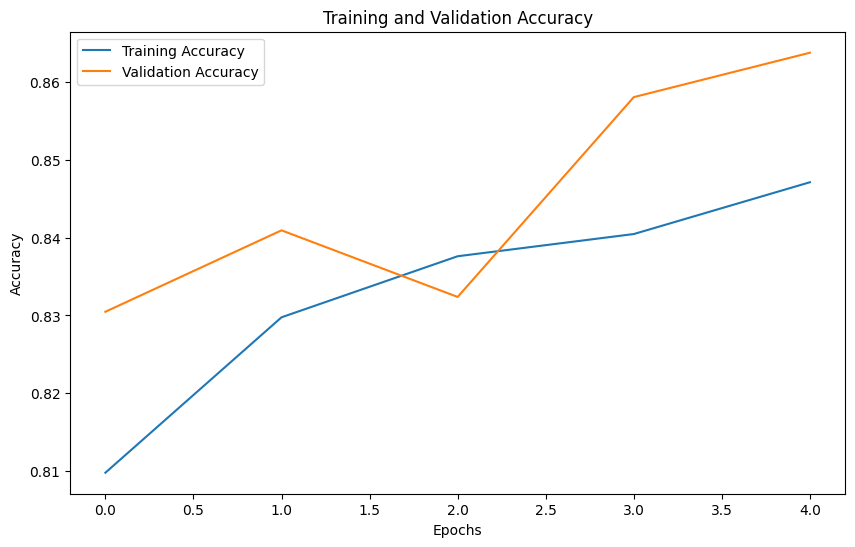

In [ ]:
import matplotlib.pyplot as plt

# Plot Training History
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()